In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

In [3]:
# Path to your GML file
gml_file_path = 'data/network-3-families.gml'

# Function to read a GML file with non-ASCII characters
def read_gml_file(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()
    content = content.decode('utf-8')
    return content

# Read and parse the GML file using NetworkX
gml_content = read_gml_file(gml_file_path)
g = nx.parse_gml(gml_content)
print(g)

Graph with 2919 nodes and 4228 edges


In [4]:
cnodes = []
c = ["RED", "GREEN", "BLUE", "YELLOW", "BLACK", "WHITE", "ORANGE (COLOR)", "PURPLE", "BROWN", "GREY"]
for node in g.nodes():
    if g.nodes[node]["Gloss"] in c:
        # print(g.nodes[node]["ID"])
        cnodes.append(node)

In [5]:
d = {}
weights = nx.get_edge_attributes(g, 'LanguageWeight')
langs = nx.get_edge_attributes(g, 'languages')

for node in g.nodes():
    edges = {}
    for a, b in list(g.edges(node)):
        try:
            edges[g.nodes[b]["Gloss"]] = {"freq"  : weights[(a,b)], "langs" : langs[(a,b)].split(";")}
        except:
            edges[g.nodes[b]["Gloss"]] = {"freq"  : weights[(b,a)], "langs" : langs[(b,a)].split(";")}

    d[g.nodes[node]["Gloss"]] = {"edges": edges}

In [6]:
d["RED"]

{'edges': {'FLAME': {'freq': 5,
   'langs': ['ids-235',
    'tryonsolomon-rennell',
    'ids-247',
    'ids-252',
    'tryonsolomon-bellona']},
  'STINKING': {'freq': 3, 'langs': ['ids-279', 'ids-299', 'suntb-Maru']},
  'DARK': {'freq': 3, 'langs': ['ids-248', 'ids-288', 'ids-173']},
  'BLOOD': {'freq': 56,
   'langs': ['transnewguineaorg-agi',
    'transnewguineaorg-gadsup',
    'transnewguineaorg-proto-madang',
    'zgraggenmadang-yaben',
    'transnewguineaorg-wagi-silibob',
    'transnewguineaorg-mum',
    'transnewguineaorg-paynamar',
    'transnewguineaorg-utarmbung',
    'zgraggenmadang-atemble',
    'transnewguineaorg-bine-sebe',
    'diacl-49300',
    'lexirumah-biak1248',
    'diacl-43600',
    'transnewguineaorg-ambulas',
    'ids-146',
    'transnewguineaorg-awa',
    'transnewguineaorg-qaget',
    'transnewguineaorg-rumu',
    'transnewguineaorg-minidien',
    'transnewguineaorg-parawen',
    'transnewguineaorg-atemble',
    'transnewguineaorg-tabo',
    'transnewguineaorg

In [7]:
def draw_subgraph(node_of_interest):
    n = str(node_of_interest)
    neighbors = list(g.neighbors(n))
    subgraph = g.subgraph([n] + neighbors)

    colour_dict = {}
    noi = [str(n) for n in cnodes]

    for node in noi.copy():
        node = str(node)
        colour_dict[node] = g.nodes[node]["Gloss"]
        neighbors = list(g.neighbors(n))

    colour_dict["1335"] = "lightgrey"

    # Draw the subgraph
    pos = nx.spring_layout(subgraph, iterations=1000, k=10)

    colour_list = list(pd.Series(pos.keys()).replace(colour_dict))

    def replace_intable(strings):
        for i in range(len(strings)):
            try:
                int(strings[i])
                strings[i] = "white"
            except ValueError:
                continue
        return strings

    colour_list = replace_intable(colour_list)
    
    plt.figure(figsize=(9,6))

    labels = nx.get_node_attributes(subgraph, 'Gloss')
    edge_labels = nx.get_edge_attributes(subgraph, 'LanguageWeight')
    edge_widths = [math.log(subgraph[u][v]['LanguageWeight'], 2) for u, v in subgraph.edges()]

    nx.draw(subgraph, pos, font_family="serif",  edge_color='lightgrey', width=edge_widths, node_size=3000, alpha=0.4, linewidths=0, node_color=colour_list)

    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_family="serif",  font_weight='bold')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_family="serif", rotate=False)

    plt.title("Subgraph of node " + labels[n], fontdict={'fontsize': 20, 'fontweight': 'bold', 'fontname': 'serif'}, pad=10)
    plt.savefig("plots/subgraph_" + labels[n] + ".png")
    plt.show()

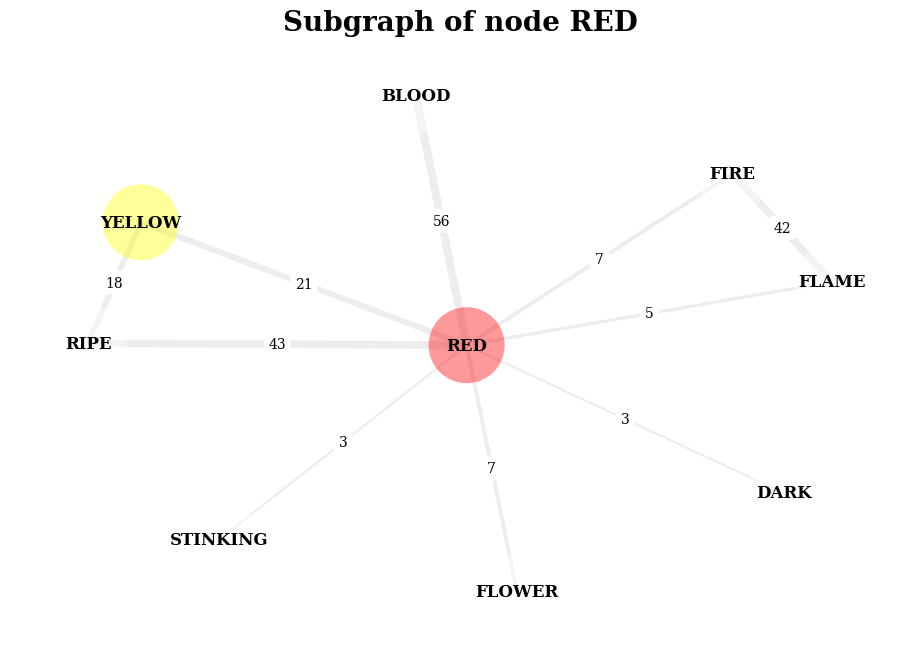

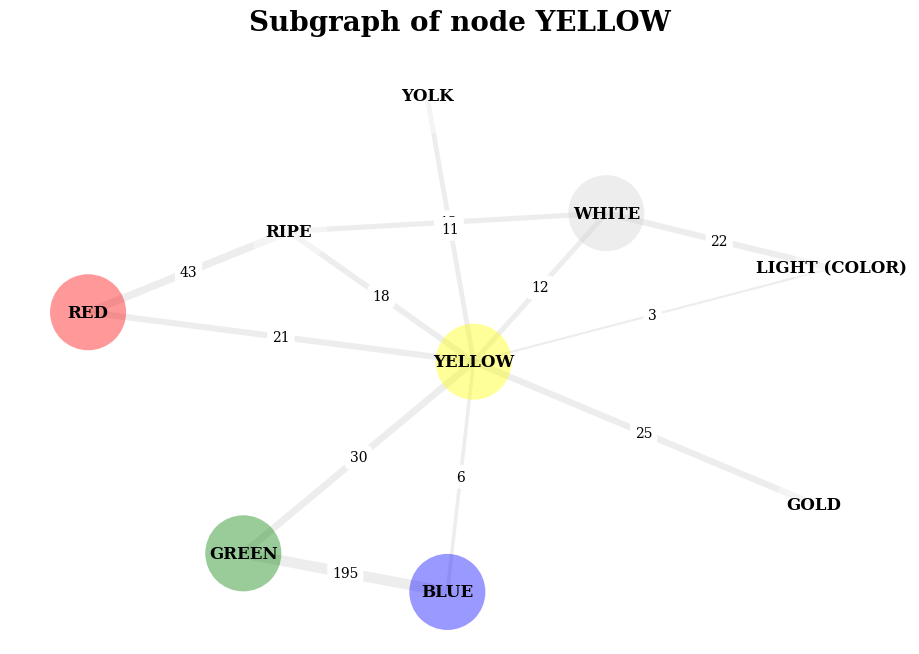

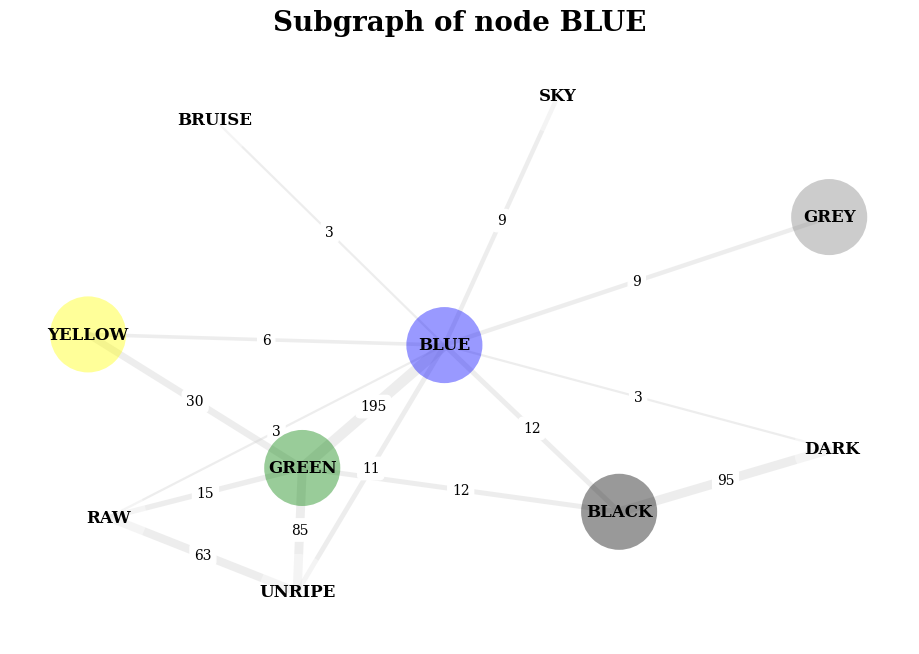

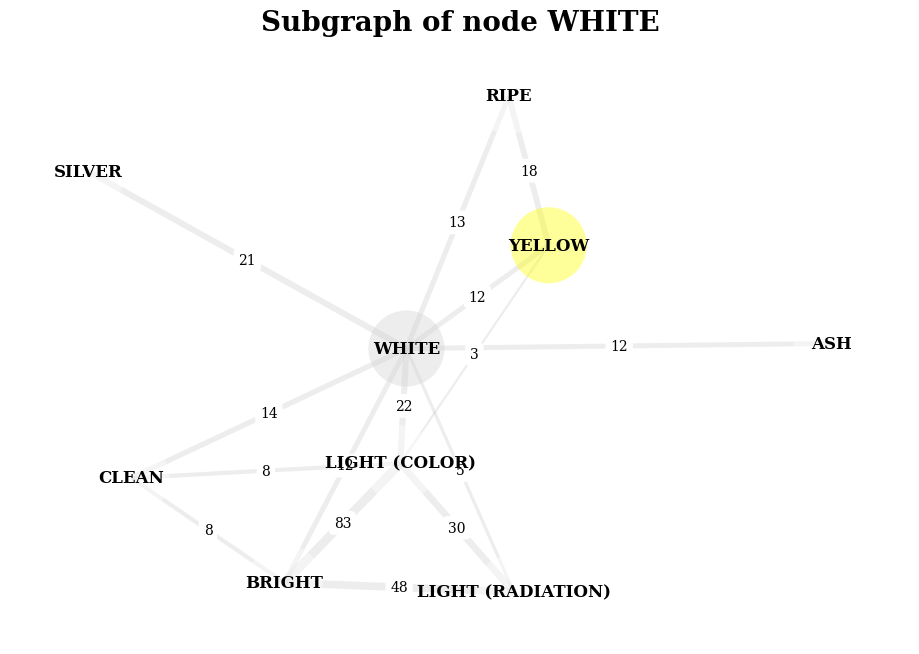

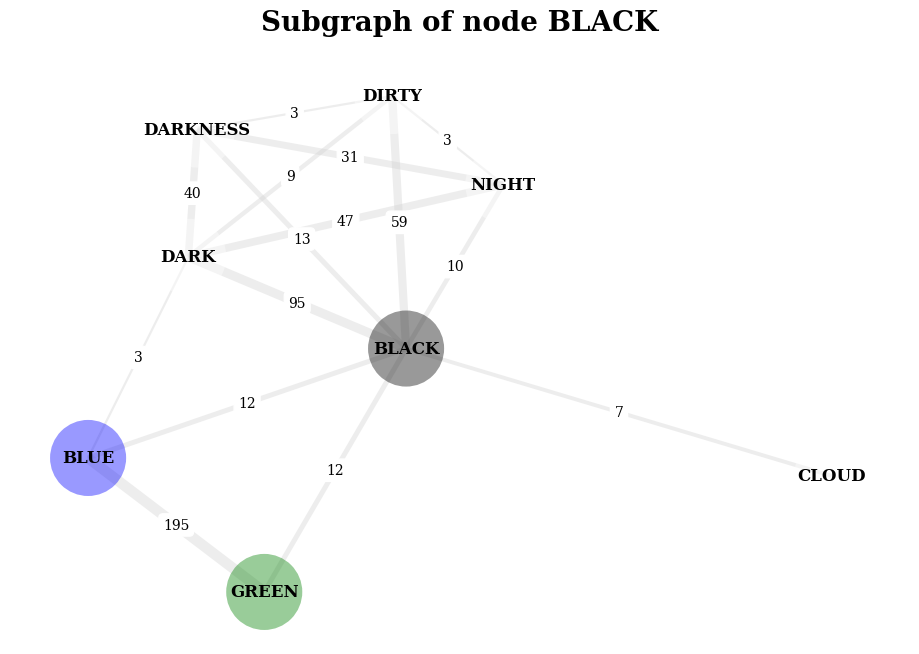

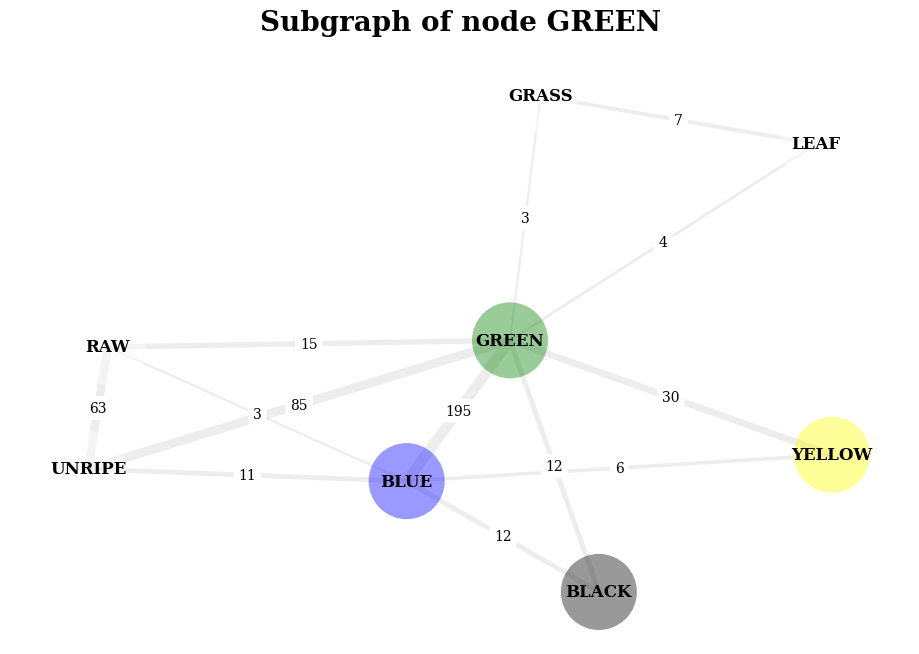

In [8]:
for node in cnodes[:6]:
    draw_subgraph(node)

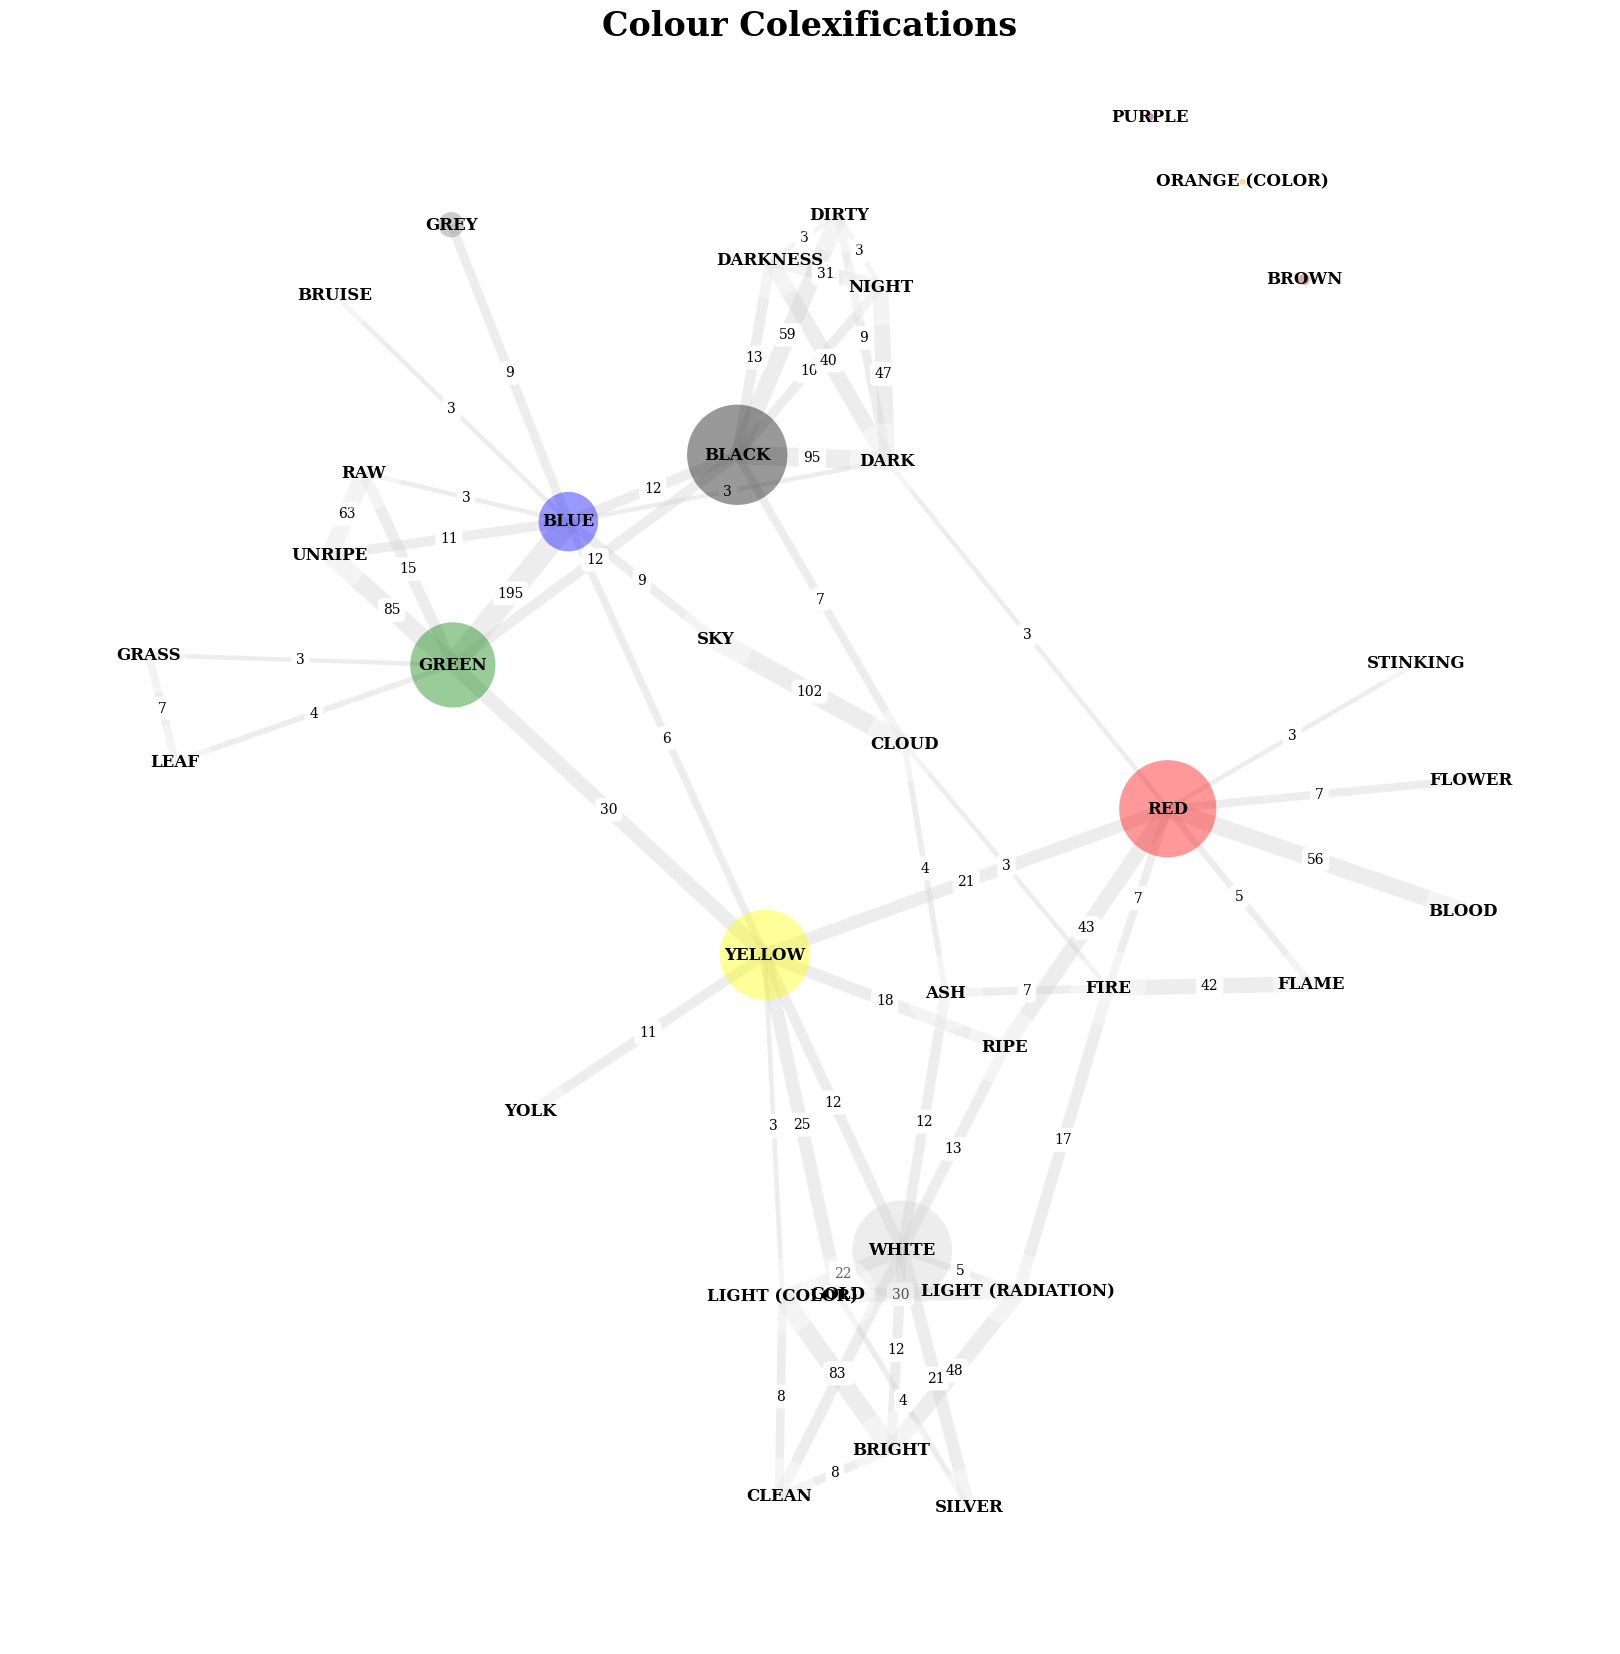

In [9]:
colour_dict = {}
node_size = {}
noi = [str(n) for n in cnodes]

for n in noi.copy():
    n = str(n)
    node_size[n] = 2* g.nodes[n]["LanguageFrequency"]
    colour_dict[n] = g.nodes[n]["Gloss"]
    neighbors = list(g.neighbors(n))
    noi = noi + neighbors

subgraph = nx.induced_subgraph(g, noi)
#subgraph = g.subgraph(noi)

colour_dict["1335"] = "lightgrey"
colour_dict["3328"] = "orange"

fixed_positions = {"3328": (92, 92), "2452": (80,100), "2409": (100,80)}

# Draw the subgraph
pos = nx.spring_layout(subgraph,  fixed=fixed_positions.keys(), pos=fixed_positions, scale=10000, iterations=100)
#pos = nx.kamada_kawai_layout(subgraph, scale=1000,)

size_list = list(pd.Series(pos.keys()).replace(node_size))
colour_list = list(pd.Series(pos.keys()).replace(colour_dict))

def replace_intable(strings):
    for i in range(len(strings)):
        try:
            int(strings[i])
            strings[i] = "white"
        except ValueError:
            continue
    return strings

colour_list = replace_intable(colour_list)

for s in size_list.copy():
    if type(s) == str:
        size_list[size_list.index(s)] = 3000

plt.figure(figsize=(16,16))

labels = nx.get_node_attributes(subgraph, 'Gloss')
edge_labels = nx.get_edge_attributes(subgraph, 'LanguageWeight')
edge_widths = [math.log(subgraph[u][v]['LanguageWeight'], 1.4) for u, v in subgraph.edges()]

nx.draw(subgraph, pos, font_family="serif",  edge_color='lightgrey', width=edge_widths, node_size=size_list, node_color=colour_list, alpha=0.4, linewidths=0)

nx.draw_networkx_labels(subgraph, pos, labels=labels, font_family="serif",  font_weight='bold')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_family="serif", rotate=False)

plt.title("Colour Colexifications", fontdict={'fontsize': 24, 'fontweight': 'bold', 'fontname': 'serif'})
plt.show()

In [10]:
g["1132"]

AtlasView({'1227': {'words': 'ids-166-7-550-2/ids-166-7-570-2;ids-240-7-550-2/ids-240-7-570-4;ids-301-7-550-1/ids-301-7-570-1;ids-302-7-550-1/ids-302-7-570-1;ids-314-7-550-1/ids-314-7-570-1', 'languages': 'ids-302;ids-240;ids-166;ids-301;ids-314', 'families': 'Austronesian;Guaicuruan;Turkic', 'wofam': 'ids-166-7-550-2/ids-166-7-570-2/tekhte/ids-166/Turkic/техте/техте;ids-240-7-550-2/ids-240-7-570-4/loloa/ids-240/Austronesian/lōloa/lōloa;ids-301-7-550-1/ids-301-7-570-1/kopak/ids-301/Guaicuruan/ḳoʔpaḳ/ḳoʔpaḳ;ids-302-7-550-1/ids-302-7-570-1/diepak/ids-302/Guaicuruan/∅-diʔ ʔepaḳ/diʔ ʔepaḳ;ids-314-7-550-1/ids-314-7-570-1/ipakmasc/ids-314/Guaicuruan/ʔipaḳ masc./ʔipaḳ masc', 'WordWeight': 5, 'FamilyWeight': 3, 'LanguageWeight': 5}, '906': {'words': 'ids-188-7-550-1/ids-188-1-420-1;ids-188-7-550-2/ids-188-1-420-2;ids-192-7-550-5/ids-192-1-420-1;ids-246-7-550-1/ids-246-1-420-1;ids-301-7-550-1/ids-301-1-420-1;ids-32-7-550-1/ids-32-1-420-1', 'languages': 'ids-32;ids-188;ids-246;ids-301;

In [13]:
def graph_by_family(fam):
    for 

<>:4: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
<>:4: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
C:\Users\yoshm\AppData\Local\Temp\ipykernel_26084\1210241706.py:4: SyntaxWarning: list indices must be integers or slices, not str; perhaps you missed a comma?
  if fam in [g.nodes[node]["Gloss"]]["edges"]:


In [14]:
graph_per_family("Indo-European")

TypeError: list indices must be integers or slices, not str